## Week 6 Homework

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import xgboost as xgb


In [106]:
# Pre processing
df = pd.read_csv('housing.csv')

df = df[['latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity']]

# Fill missing values
df = df.fillna(0)

##  For quesiton 6 ###
## need to rename ocean_proximity=<1H OCEAN' as XG boost does not like one bit
#df['ocean_proximity'] = df['ocean_proximity'].map({'<1H OCEAN': 'LESS1H OCEAN'})
df['ocean_proximity'].replace(['<1H OCEAN'], ['LESS1H OCEAN'], inplace=True)


# Log transform median_house_value
df['log_median_house_value'] = np.log(df['median_house_value'])

# test / train / validation split
X = df.drop(columns=['median_house_value', 'log_median_house_value'])
y = df['log_median_house_value']
# Split into test and train at 60/40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)

# now split into train and validation to give 60/20/20 split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)


# use dict vectorizer
numeric = ['latitude', 'longitude','housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
categoric = ['ocean_proximity']

# One hot encode categoricals using a dict vectorizer
train_dict = X_train[categoric + numeric].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

# One hot encode test data for model metrics
test_dict = X_test[categoric + numeric].to_dict(orient='records')
X_test = dv.transform(test_dict)

# One hot encode validation data for model metrics
val_dict = X_val[categoric + numeric].to_dict(orient='records')
X_val = dv.transform(val_dict)





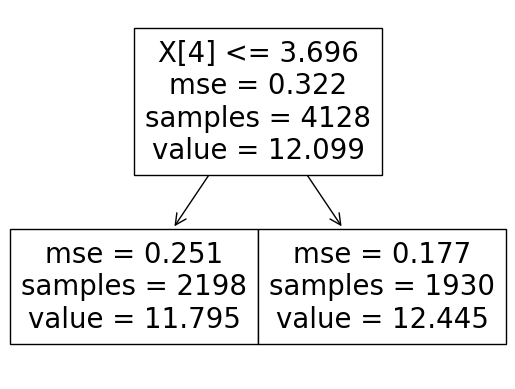

In [64]:
# Question 1
dt = DecisionTreeRegressor(max_depth=1)
regressor = dt.fit(X_train, y_train)

tree.plot_tree(regressor)
plt.show()

In [23]:
# Question 2
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model = rf.fit(X_train, y_train)


y_pred = model.predict(X_val)
print(f"RMSE is: {round(mean_squared_error(y_val, y_pred, squared=False),3)}")

RMSE is: 0.277


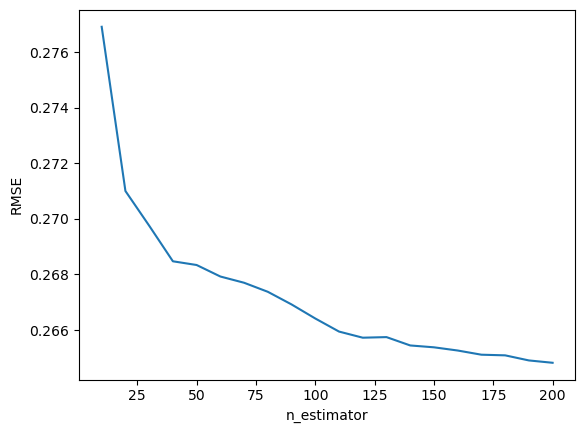

In [66]:
# Question 3
estimators = np.linspace(10,200, num=20).astype(int)
metrics = []
for estimator in estimators:
    rf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    model = rf.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    metrics.append(rmse)
    

plt_df = pd.DataFrame(data={'n_estimator': estimators, 'RMSE': metrics})
sns.lineplot(x='n_estimator',
             y='RMSE',
             data=plt_df)
plt.show()

In [78]:
# Question 4
max_depths = [10, 15, 20, 25]
estimators = np.linspace(10,200, num=20).astype(int)

modelling_results = {}
for max_depth in max_depths:
    metrics = []
    for estimator in estimators:
        rf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1, max_depth=max_depth)
        model = rf.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        metrics.append(rmse)
    # take the average of all the RMSE values for this estimator and appeand to dict    
    modelling_results[max_depth] = round(sum(metrics)/len(metrics),3)

In [79]:
modelling_results

{10: 0.273, 15: 0.268, 20: 0.268, 25: 0.267}

In [85]:
## Question 5
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
model = rf.fit(X_train, y_train)
list(zip(dv.feature_names_, model.feature_importances_))

[('households', 0.024207069518935708),
 ('housing_median_age', 0.0401341746971968),
 ('latitude', 0.0763191775374188),
 ('longitude', 0.07751126674967361),
 ('median_income', 0.4608823885448403),
 ('ocean_proximity=<1H OCEAN', 0.0023436142443200134),
 ('ocean_proximity=INLAND', 0.22699533385971019),
 ('ocean_proximity=NEAR BAY', 0.0003781183956557871),
 ('ocean_proximity=NEAR OCEAN', 0.0037659822689076745),
 ('population', 0.037713617987022836),
 ('total_bedrooms', 0.023973137440235392),
 ('total_rooms', 0.02577611875608293)]

In [110]:
# Question 6

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

etas = [0.1, 0.3]

for eta in etas:
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    watchlist = [(dtrain, 'train'), (dval, 'val')]

    model = xgb.train(xgb_params, dtrain,
                    num_boost_round=100,
                    evals=watchlist, verbose_eval=10)
    print('-------------- Onto the next model--------------------')

[0]	train-rmse:10.45386	val-rmse:10.43699
[10]	train-rmse:3.66383	val-rmse:3.65468
[20]	train-rmse:1.31066	val-rmse:1.30858
[30]	train-rmse:0.51316	val-rmse:0.52574
[40]	train-rmse:0.27191	val-rmse:0.31111
[50]	train-rmse:0.21063	val-rmse:0.27056
[60]	train-rmse:0.18969	val-rmse:0.26151
[70]	train-rmse:0.17755	val-rmse:0.25879
[80]	train-rmse:0.16766	val-rmse:0.25615
[90]	train-rmse:0.15967	val-rmse:0.25436
[99]	train-rmse:0.15498	val-rmse:0.25352
-------------- Onto the next model--------------------
[0]	train-rmse:8.13687	val-rmse:8.12254
[10]	train-rmse:0.33851	val-rmse:0.36534
[20]	train-rmse:0.18604	val-rmse:0.26545
[30]	train-rmse:0.15936	val-rmse:0.25887
[40]	train-rmse:0.14261	val-rmse:0.25798
[50]	train-rmse:0.12859	val-rmse:0.25658
[60]	train-rmse:0.11568	val-rmse:0.25591
[70]	train-rmse:0.10437	val-rmse:0.25547
[80]	train-rmse:0.09390	val-rmse:0.25474
[90]	train-rmse:0.08717	val-rmse:0.25444
[99]	train-rmse:0.08250	val-rmse:0.25452
-------------- Onto the next model---------

In [ ]:
# Repeat again with eta at 0.1